In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
sns.set(style="darkgrid")
%matplotlib inline

/Users/chandler/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
data = pd.read_excel('returns_OCT.xlsx', index_col='time')

p_len = 12
df = data.pct_change(p_len)
df = df.iloc[p_len:]

rets = df.loc[:,(df.applymap(lambda x: x < 5).all(axis=0) == True)]
rets.head()

,BTC,ETH,XRP,BCH,LTC,DASH,XEM,NEO,XMR,ETC,...,BITB,EXCL,HTML5,EQT,CURE,IOP,NOTE,DYN,TRUST,ABY
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 05:00:00,-0.022584,0.081423,0.002857,0.007593,-0.000879,0.016809,-0.017665,-0.050527,-0.020588,0.003791,...,0.161765,-0.214703,1.0,0.0,-0.004367,-0.012698,0.045045,-0.021216,-0.122106,-0.021053
2017-08-21 06:00:00,-0.032604,0.118066,0.019428,-0.016929,0.008865,0.028023,-0.018125,-0.025236,0.001515,0.028690,...,-0.107143,-0.084021,0.0,0.0,-0.021837,-0.008706,0.031697,-0.015602,-0.123529,-0.005376
2017-08-21 07:00:00,-0.029767,0.100378,0.026323,-0.061471,0.009786,0.002531,-0.009507,-0.076956,0.279731,0.025283,...,-0.316327,0.174538,0.0,0.0,0.005654,-0.032960,0.007960,0.027808,-0.131030,-0.031579
2017-08-21 08:00:00,-0.013811,0.094719,0.009595,-0.089674,-0.007061,0.008607,-0.046082,-0.067407,0.540763,0.021043,...,-0.244444,0.111232,0.0,0.0,0.025136,-0.017067,-0.018627,-0.020842,-0.201734,-0.021277
2017-08-21 09:00:00,-0.014801,0.086387,-0.014960,-0.115966,-0.003546,-0.013870,-0.039839,-0.080645,0.574644,0.006497,...,-0.116883,0.077006,0.0,0.0,0.003777,-0.015277,-0.031220,0.010526,-0.219298,-0.010811


In [26]:
symbols = rets.columns
noa = len(symbols)

In [29]:
weights = np.random.random(noa)
weights /= np.sum(weights)
len(weights)

202

In [30]:
np.sum(rets.mean() * weights) * 252 * 2

1.5812528495131766

In [34]:
np.dot(weights.transpose(), np.dot(rets.cov() * 252 * 2, weights))

0.36270632826420934

In [104]:
prets = []
pvols = []

for p in range(25000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252 * 2)
    pvols.append(np.dot(weights.transpose(), np.dot(rets.cov() * 252 * 2, weights)))
prets = np.array(prets)
pvols = np.array(pvols)


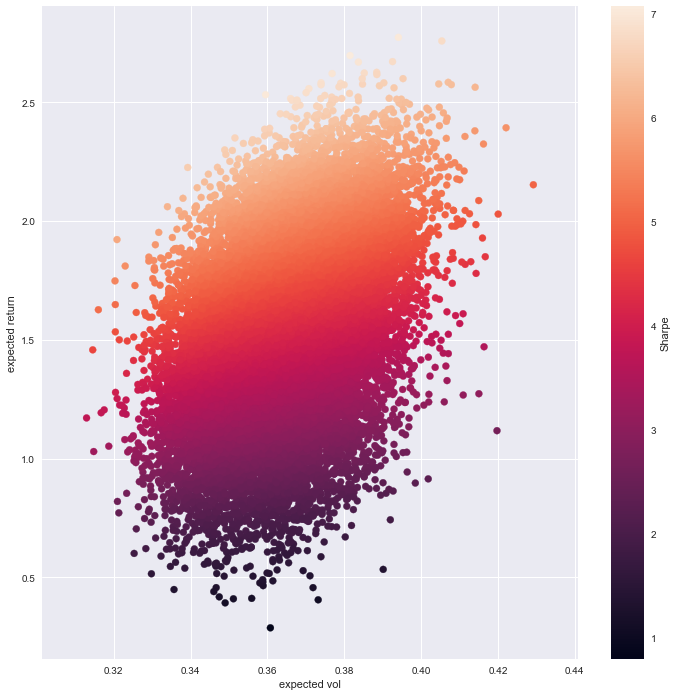

In [107]:
plt.figure(figsize=(12, 12))
plt.scatter(pvols, prets, c= prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected vol')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe')

#### Optimize time
# http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html 

In [40]:
import scipy.optimize as sco

In [90]:
def statistics(weights):
    ''' Returns portfolio statistics
    
    Parameters
    ==========
    weights : array-like
        weights for diffeerent securities in portfolio
    
    Returns
    =========
    pret: float
        expected portfolio return
    pvol : float
        expected portfolio vol
    pret / pvol : float
        Sharpe ratio for rf=0
    
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252 * 2
    pvol = np.dot(weights.transpose(), np.dot(rets.cov() * 252 * 2, weights))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    '''minimizes the negative value of the sharpe ratio'''
    return -statistics(weights)[2]

def min_func_variance(weights):
    return statistics(weights)[1] ** 2

def min_func_port(weights):
    return statistics(weights)[1]

In [77]:
#'''all weights add up to one'''

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# parameter values must be within 0 and 1
bnds = tuple((0, 1) for x in range(noa))

# equal distribution for starting point
equalweight = noa * [1. / noa]

### Maximize Sharpe

In [78]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                   bounds=bnds, constraints=cons)

In [85]:
ropts = opts['x'].round(3)
ropts = ropts / np.sum(ropts)

In [80]:
statistics(y)

array([  4.31288909e-01,   1.33435738e-03,   3.23218439e+02])

### Minimizing the variance



In [81]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                   bounds=bnds, constraints=cons)

In [82]:
optv

     fun: 1.1389859072546512e-05
     jac: array([  2.20965012e-04,   1.33176643e-05,   7.41648913e-05,
        -1.90455478e-05,   9.06506830e-06,  -9.93752246e-06,
         2.36321009e-05,   3.03151094e-05,  -1.61323492e-05,
        -2.31496958e-05,   5.40133500e-05,   1.13467578e-04,
         5.03921061e-05,  -9.07162769e-06,   5.01042234e-05,
        -5.72108879e-05,   8.23526768e-05,   4.36980330e-05,
        -2.36675376e-05,   6.12495127e-05,   4.67744078e-05,
         1.21509271e-04,  -3.97825046e-05,  -3.44933235e-05,
         5.38340363e-05,   2.54688343e-05,   1.79457709e-05,
         7.36639123e-05,   4.56275113e-05,  -6.87887585e-05,
         2.69051179e-05,   4.68069757e-05,   1.10143962e-04,
         8.82317522e-05,   1.05167667e-04,   2.32258230e-06,
         1.40640355e-04,  -1.41034923e-05,   4.68496845e-05,
        -3.59635476e-06,   2.28580714e-04,  -8.22067761e-06,
         8.04441128e-05,   1.38875661e-04,   2.50656589e-05,
         4.50919800e-05,   6.43131700e-05,

In [100]:
roptv = optv['x']
roptv = roptv / np.sum(roptv)

statistics(roptv)

array([  2.33760338e-01,   3.37488653e-03,   6.92646512e+01])

### Efficient Frontier

In [101]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
       {'type': 'eq', 'fun': lambda x: np.sum(x) -1})
bnds = tuple((0, 1) for x in weights)

In [106]:
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

KeyboardInterrupt: 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

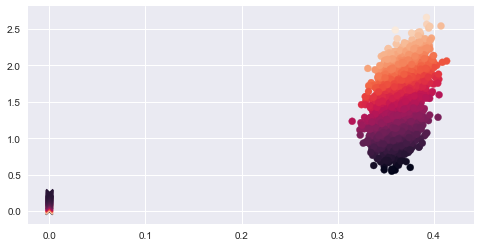

In [103]:
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.scatter(tvols, trets, c=trets /tvols, marker = 'x')
plt.plot(statistics(ropts['x'])[1], statistics(ropts['x'][0]), 'r*', markersize=15.0)
plt.plot(statistics(roptv['x'])[1], statistics(roptv['x'][0]), 'r*', markersize=15.0)

plt.grid(True)
plt.xlabel('Expected Vol')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [ ]:

from cvxopt import matrix, solvers

In [ ]:
def optimize_portfolio(n, avg_ret, covs, r_min):
    P = covs
    # x = variable(n)
    q = matrix(np.zeros((n, 1)), tc='d')
    # inequality constraints Gx <= h
    # captures the constraints (avg_ret'x >= r_min) and (x >= 0)
    G = matrix(np.concatenate((
        -np.transpose(np.array(avg_ret)), 
        -np.identity(n)), 0))
    h = matrix(numpy.concatenate((
        -np.ones((1,1))*r_min, 
        np.zeros((n,1))), 0))
    # equality constraint Ax = b; captures the constraint sum(x) == 1
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    return sol

def get_returns(symbol, start, end, interval='m'):
    history = data(symbol, start, end, interval)
    prices = map(lambda x: round(float(x),2), history['Close'])
    prices[0] = round(float(history['Open'][0]),2)
    returns = map(lambda (x, y): (y/x)-1, zip(prices[0:-1], prices[1:]))
    return returns

def get_yr_returns(symbol, start, end):
    history = quote_history_dict(symbol, start, end, 'm')
    prices = map(lambda x: round(float(x),2), history['Close'])
    prices[0] = round(float(history['Open'][0]),2)
    prices.insert(0, prices[0])
    returns = map(lambda (x, y): (y/x)-1, zip(prices[0::12][:-1], prices[12::12]))
    return returns



def avg_return(symbol, start, end, interval='h'):
    if interval=='y':
        return np.mean(get_yr_returns(symbol, start, end))
    else:
        return np.mean(get_returns(symbol, start, end, interval))

In [ ]:
symbols = df_vol.columns
n = len(symbols)
start = df_vol.index[0]
end = df_vol.index[-1]

avg_ret = matrix(map(lambda s: avg_return(s, start, end, 'h'), symbols))